# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [ ]:
!unzip ATnT.zip

Archive:  ATnT.zip
   creating: ATnT/
  inflating: __MACOSX/._ATnT         
   creating: ATnT/s34/
  inflating: __MACOSX/ATnT/._s34     
   creating: ATnT/s33/
  inflating: __MACOSX/ATnT/._s33     
   creating: ATnT/s5/
  inflating: __MACOSX/ATnT/._s5      
   creating: ATnT/s2/
  inflating: __MACOSX/ATnT/._s2      
   creating: ATnT/s32/
  inflating: __MACOSX/ATnT/._s32     
   creating: ATnT/s35/
  inflating: __MACOSX/ATnT/._s35     
   creating: ATnT/s3/
  inflating: __MACOSX/ATnT/._s3      
   creating: ATnT/s4/
  inflating: __MACOSX/ATnT/._s4      
   creating: ATnT/s26/
  inflating: __MACOSX/ATnT/._s26     
   creating: ATnT/s19/
  inflating: __MACOSX/ATnT/._s19     
   creating: ATnT/s21/
  inflating: __MACOSX/ATnT/._s21     
   creating: ATnT/s17/
  inflating: __MACOSX/ATnT/._s17     
   creating: ATnT/s28/
  inflating: __MACOSX/ATnT/._s28     
   creating: ATnT/s10/
  inflating: __MACOSX/ATnT/._s10     
   creating: ATnT/s11/
  inflating: __MACOSX/ATnT/._s11     
   creating: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    # Flattening the images
    X_flat = X.reshape(X.shape[0], -1)

    # Centering the data
    mean_face = np.mean(X_flat, axis=0)
    centered_data = X_flat - mean_face

    # Computing covariance matrix
    # rowvar=False i.e. each column represents a variable, and the rows contain observations.
    cov_matrix = np.cov(centered_data, rowvar=False)

    # Computing eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sorting eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Selecting the top numComponents eigenvectors
    eigenfaces = sorted_eigenvectors[:, :numComponents]

    return eigenfaces

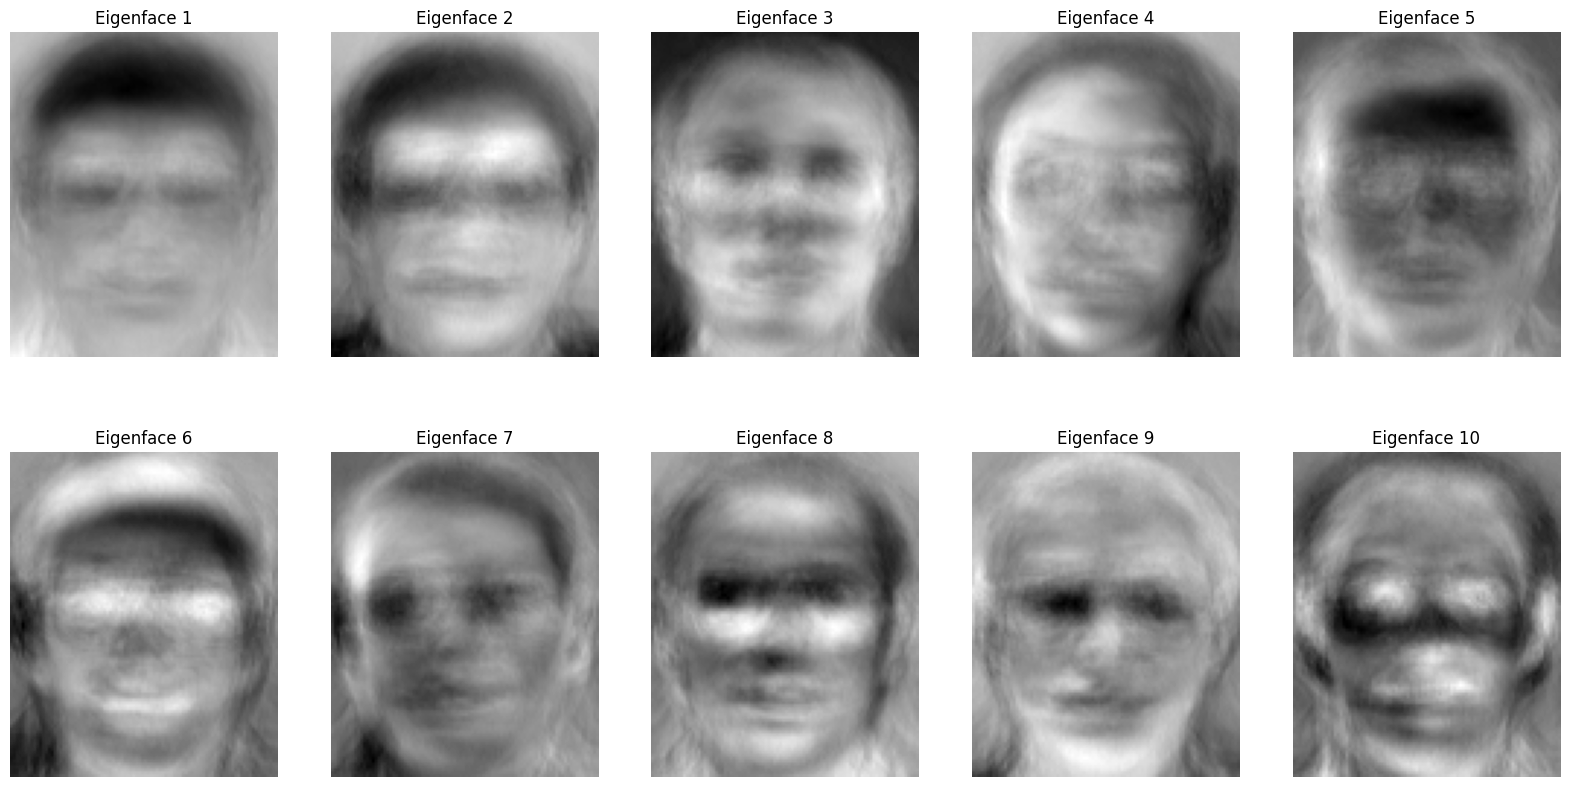

In [ ]:
# plot the eigen faces
%matplotlib inline

# Number of principal components (Eigenfaces)
# Creating 100 eigen faces, but plotting only 10
num_components = 100

# Performing PCA
eigenfaces = principalComponentAnalysis(trainFaces, num_components)

# Plotting only 10 out of the 100 Eigenfaces
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[:, i].reshape(112, 92), cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')
plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """

    # Flattening the test face
    testFace_flat = testFace.reshape(-1, 1)

    # Centering the test face
    centered_testFace = testFace_flat - meanFace.reshape(-1, 1)

    # Projecting the test face onto the Eigenfaces to obtain the Eigen-coefficients
    eigenCoefficients = np.dot(eigenFaces.T, centered_testFace)

    # Reconstructing the test face using the Eigen-coefficients and Eigenfaces
    reconstructedFace_flat = np.dot(eigenFaces, eigenCoefficients)

    # Adding back the mean face to the reconstructed face
    reconstructedFace_flat += meanFace.reshape(-1, 1)

    # Reshaping the reconstructed face to its original shape
    reconstructedFace = reconstructedFace_flat.reshape(testFace.shape)

    return reconstructedFace

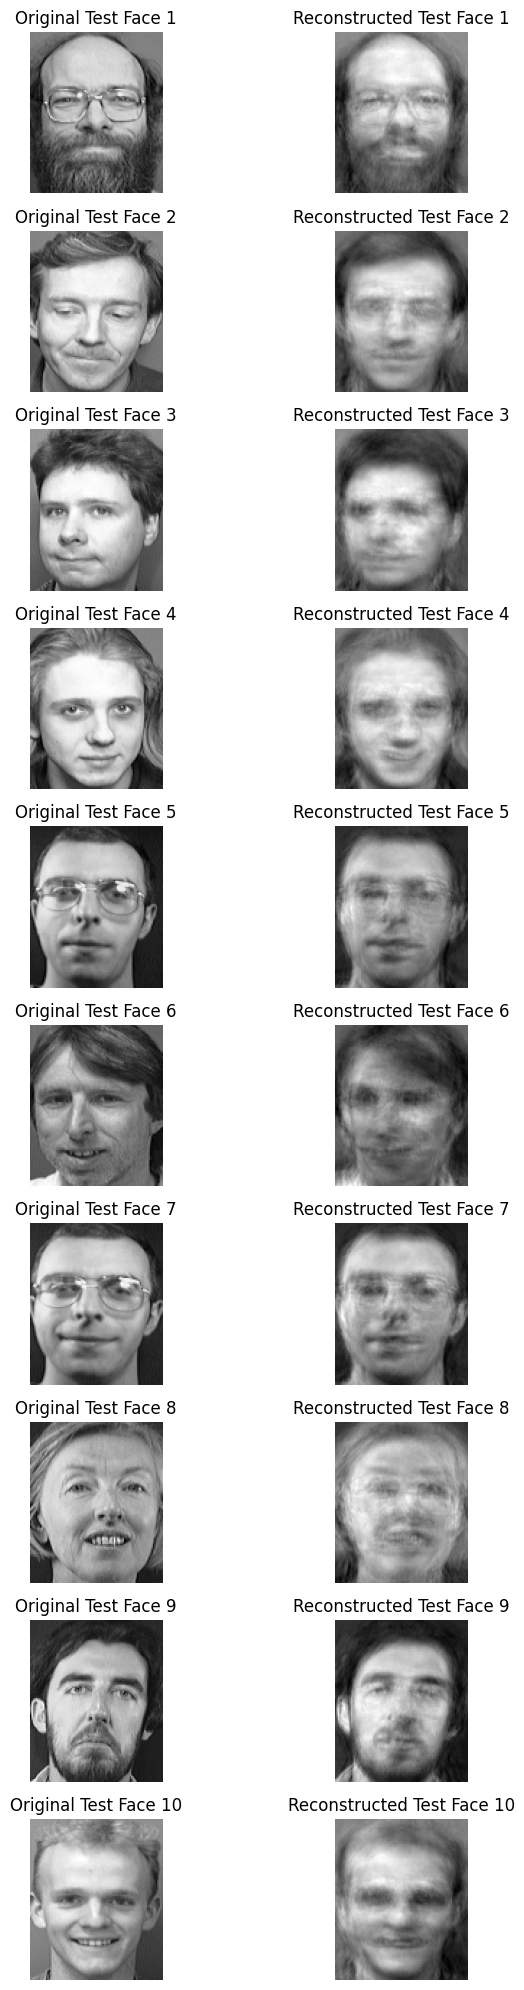

In [ ]:
# plot recontructions here
%matplotlib inline

# Number of test faces to reconstruct and visualize
num_test_faces = 10

plt.figure(figsize=(8, 20))
for i in range(num_test_faces):
    # Reconstruct the i-th test face
    reconstructed_face = imageReconstruction(testFaces[i], eigenfaces, np.mean(trainFaces, axis=0))

    # Plot the original test face
    plt.subplot(num_test_faces, 2, 2*i + 1)
    plt.imshow(testFaces[i], cmap='gray')
    plt.title(f'Original Test Face {i+1}')
    plt.axis('off')

    # Plot the reconstructed test face
    plt.subplot(num_test_faces, 2, 2*i + 2)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title(f'Reconstructed Test Face {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

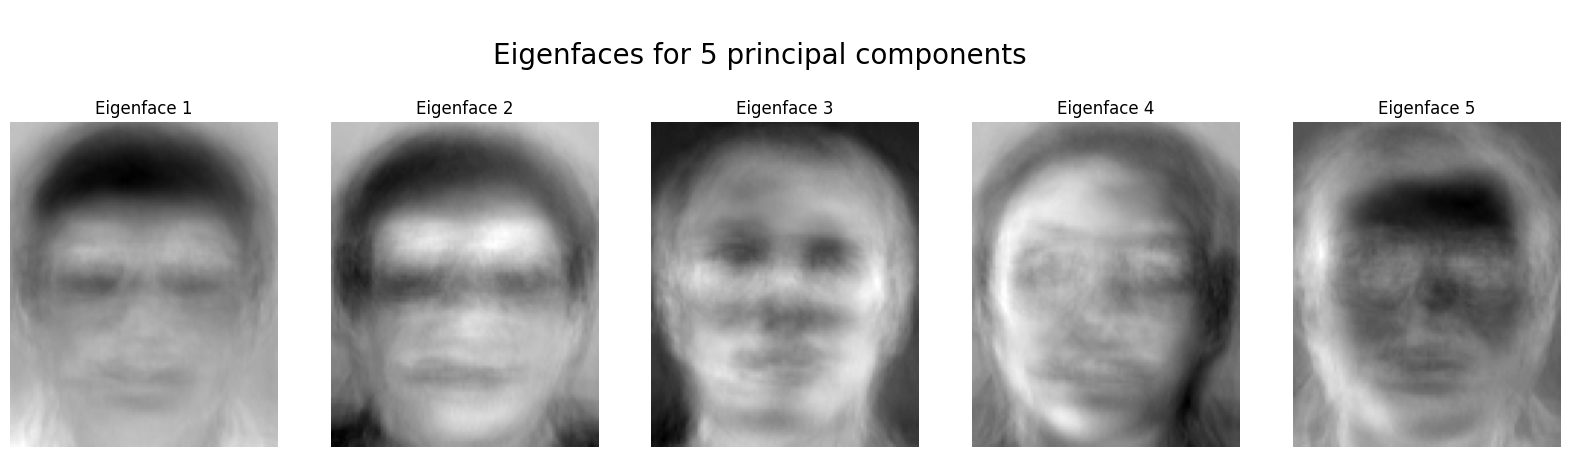

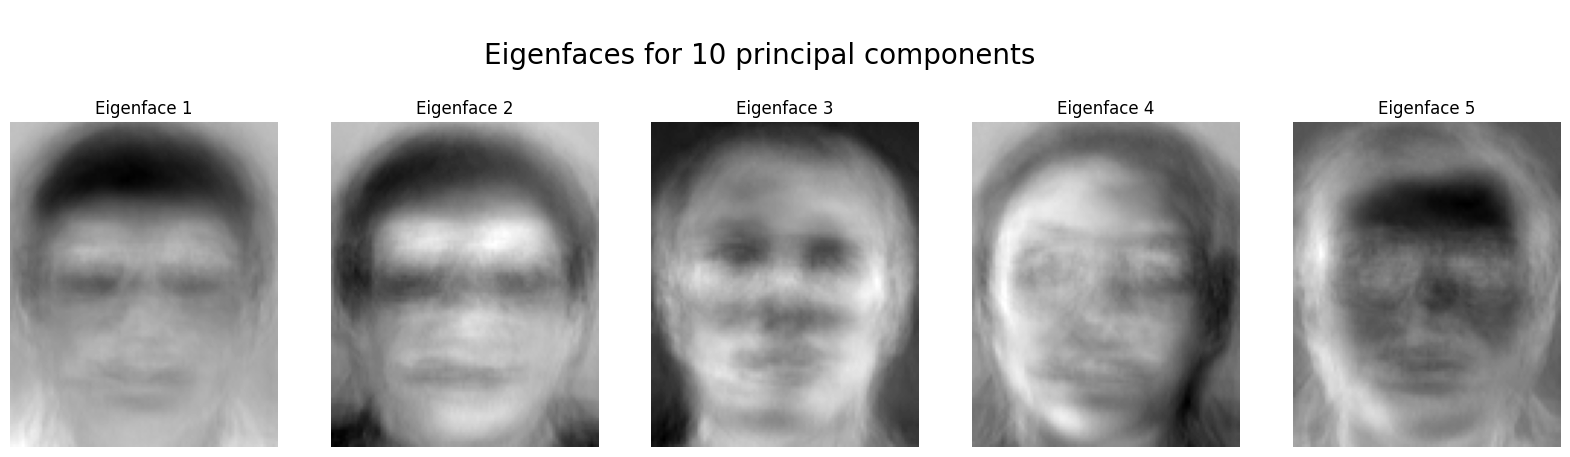

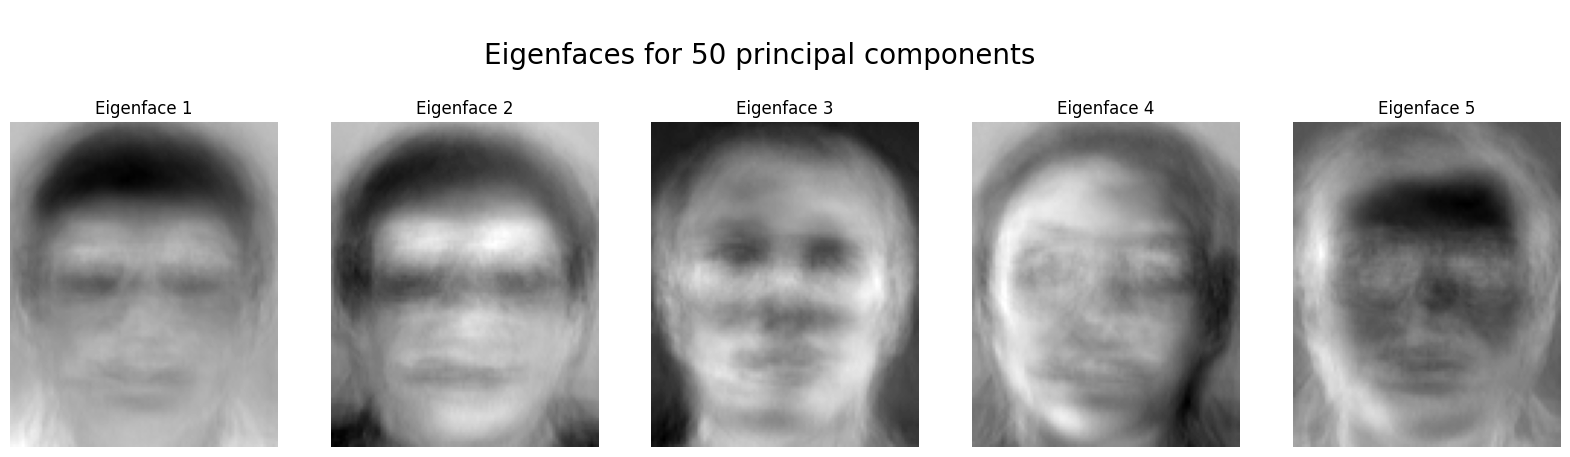

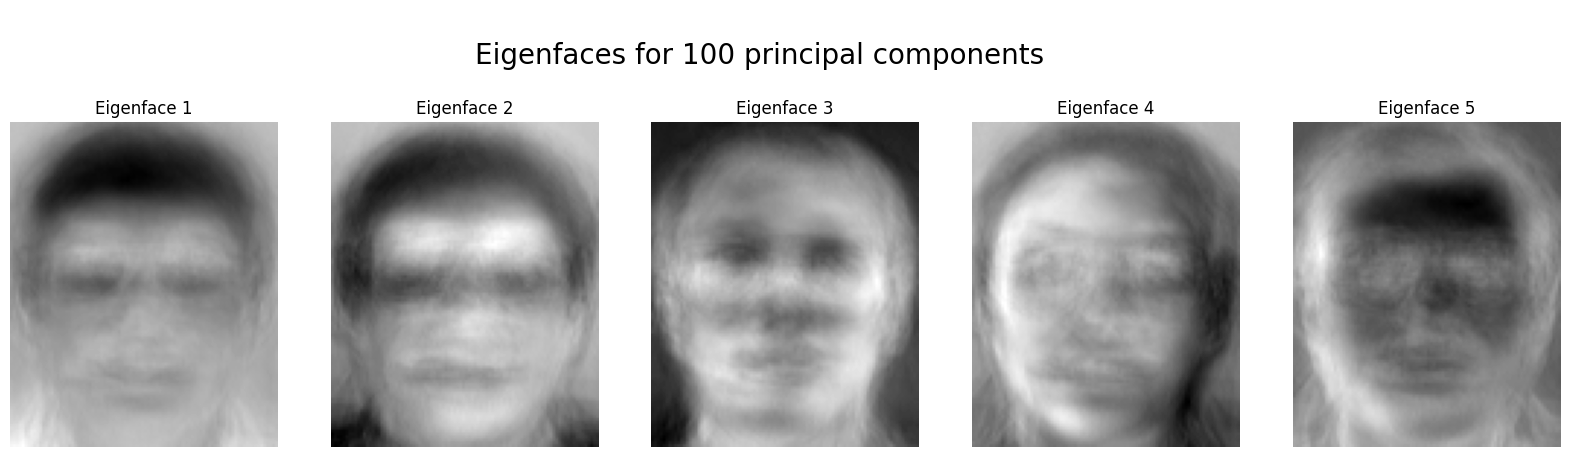

In [ ]:
%matplotlib inline

def displayNfactors(trainFaces, num_factors_list):

    for num_components in num_factors_list:
        # Performing PCA
        eigenfaces = principalComponentAnalysis(trainFaces, num_components)

        # Plotting the Eigenfaces
        plt.figure(figsize=(20, 10))
        for i in range(5):  # Plotting only the first 5 Eigenfaces
            plt.subplot(2, 5, i + 1)
            plt.imshow(eigenfaces[:, i].reshape(112, 92), cmap='gray')
            plt.title(f'Eigenface {i+1}')
            plt.axis('off')
        plt.suptitle(f'\nEigenfaces for {num_components} principal components', fontsize=20)
        plt.show()


# List of numbers of principal components to visualize
num_factors_list = [5, 10, 50, 100]


# Call the function to display Eigenfaces for different numbers of principal components
displayNfactors(trainFaces, num_factors_list)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
def getClass(test_image, eigenfaces, mean_face, X_train, y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    min_error = float('inf')
    best_match = None
    predicted_class = None

    # Flattening the test image
    test_image_flat = test_image.reshape(-1, 1)

    # Centering the test image
    centered_test_image = test_image_flat - mean_face.reshape(-1, 1)

    # Projecting the test image onto the Eigenfaces to obtain the Eigen-coefficients
    eigen_coefficients = np.dot(eigenfaces.T, centered_test_image)

    # Reconstructing the test image using the Eigen-coefficients and Eigenfaces
    reconstructed_image_flat = np.dot(eigenfaces, eigen_coefficients)

    # Adding back the mean face to the reconstructed image
    reconstructed_image_flat += mean_face.reshape(-1, 1)

    # Calculating the error for each training image
    for i in range(len(X_train)):
        # Flattening the training image
        train_image_flat = X_train[i].reshape(-1, 1)

        # Computing the error (L2 norm)
        error = np.linalg.norm(reconstructed_image_flat - train_image_flat)

        # Updating min_error and best_match if current error is smaller
        if error < min_error:
            min_error = error
            best_match = X_train[i]
            predicted_class = y_train[i]

    return best_match, min_error, predicted_class

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [ ]:
components = [3,5,10,20,30,40,50]
mse = []
accuracies = []

for numComponents in components:
    correct_predictions = 0
    total_samples = len(testFaces)

    for i in range(total_samples):
        # Geting the test image and its true label
        test_image = testFaces[i]
        true_label = testLabels[i]

        # Performing face recognition using numComponents
        best_match, _, predicted_class = getClass(test_image, eigenfaces[:, :numComponents], np.mean(trainFaces, axis=0), trainFaces, trainLabels)

        # Checking if the predicted class matches the true label
        if predicted_class == true_label:
            correct_predictions += 1

    # Calculating accuracy
    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    # Calculating mean square error
    mse_sum = 0
    for i in range(total_samples):
        test_image = testFaces[i]
        true_label = testLabels[i]

        # Performing face recognition using numComponents
        best_match, min_error, _ = getClass(test_image, eigenfaces[:, :numComponents], np.mean(trainFaces, axis=0), trainFaces, trainLabels)

        # Computing the mean square error
        mse_sum += min_error ** 2

    mean_squared_error = mse_sum / total_samples
    mse.append(mean_squared_error)

    print(f"Accuracy for {numComponents} principle components : {accuracy}")


Accuracy for 3 principle components : 0.325
Accuracy for 5 principle components : 0.625
Accuracy for 10 principle components : 0.9
Accuracy for 20 principle components : 0.95
Accuracy for 30 principle components : 0.95
Accuracy for 40 principle components : 0.95
Accuracy for 50 principle components : 0.95


Plot Number of eigenvectors vs Mean Square Error

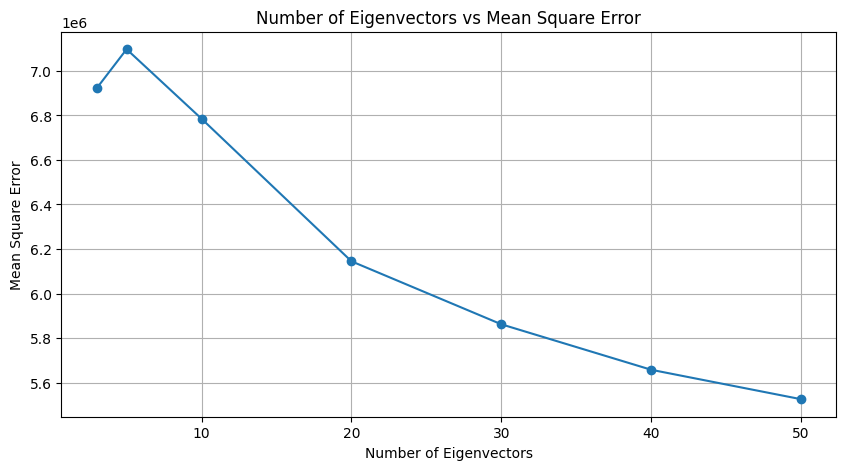

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(components, mse, marker='o')
plt.title('Number of Eigenvectors vs Mean Square Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Square Error')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

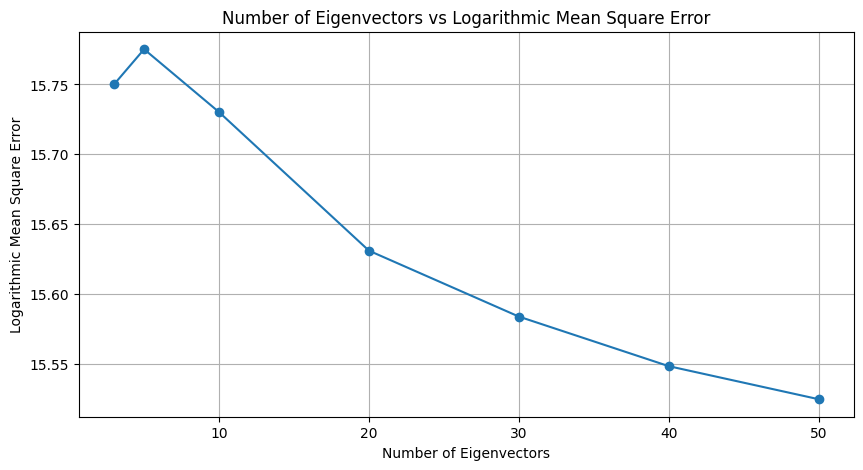

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(components, np.log(mse), marker='o')
plt.title('Number of Eigenvectors vs Logarithmic Mean Square Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Logarithmic Mean Square Error')
plt.grid(True)
plt.show()